In [1]:
from numba import jit
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numba
import math
from numba import cuda
from timeit import default_timer as timer
from matplotlib.pylab import imshow, show

In [2]:
print(np.__version__)
print(numba.__version__)
cuda.detect()

1.26.4
0.60.0
Found 1 CUDA devices
id 0    b'NVIDIA GeForce MX150'                              [SUPPORTED]
                      Compute Capability: 6.1
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-ad342e91-951f-2803-4fff-0137ec55bc5f
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
%pip install --upgrade cuda-python
from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Inicializar CUDA 
(err,) = cuInit(0)

In [5]:
# Sacar los atributos
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

In [6]:
print(f"Nombre de la tarjeta grafica: {DEVICE_NAME}")
print(f"Numero maximo de procesadores: {SMs}")
print(f"Numero maximo de hilos por bloque: {MAX_THREADS_PER_BLOCK:10}")
print(f"Numero maximo de bloques por matriz:   {MAX_BLOCK_DIM_X:10}")
print(f"Numero maximo de hilos por matriz:  {MAX_GRID_DIM_X:10}")

Nombre de la tarjeta grafica: NVIDIA GeForce MX150                                                                                                           
Numero maximo de procesadores: 3
Numero maximo de hilos por bloque:       1024
Numero maximo de bloques por matriz:         1024
Numero maximo de hilos por matriz:  2147483647


In [7]:
@cuda.jit
def matmul(foto, filtro, resultado):
    """Perform 2-dimensional convolution of C = A * B."""
    i, j = cuda.grid(2)
    if i < resultado.shape[0] and j < resultado.shape[1]: # Comprueba que el índice no sobrepase el tamaño de la matriz
        tmp = 0.  # Variable temporal para almacenar el valor de la multiplicación

        for k in range(-filtro.shape[0]//2 + 1, filtro.shape[0]//2 + 1): # Recorre el filtro
            for l in range(-filtro.shape[1]//2 + 1, filtro.shape[1]//2 + 1):  # Recorre el filtro
                if 0 <= i - k < foto.shape[0] and 0 <= j - l < foto.shape[1]: # Comprueba que el índice no sobrepase el tamaño de la matriz
                    tmp += foto[i-k, j-l] * filtro[k+filtro.shape[0]//2, l+filtro.shape[1]//2] # Realiza la multiplicacións

        resultado[i, j] = tmp  # Guarda el resultado en la matriz resultado

## Cargar la foto y cambiar de tamaño la foto

Tamaño de la foto:  (198, 300)


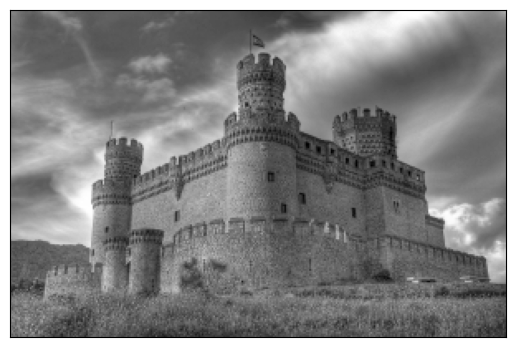

Tamaño de la foto:  (396, 600)


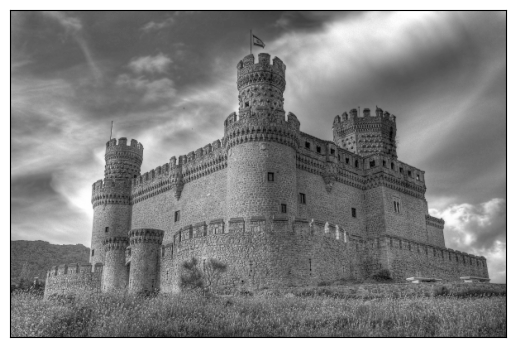

Tamaño de la foto:  (792, 1200)


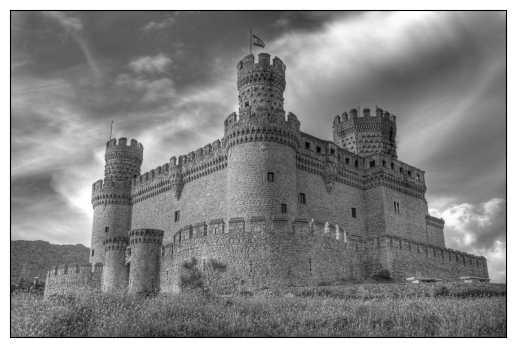

Tamaño de la foto:  (1584, 2400)


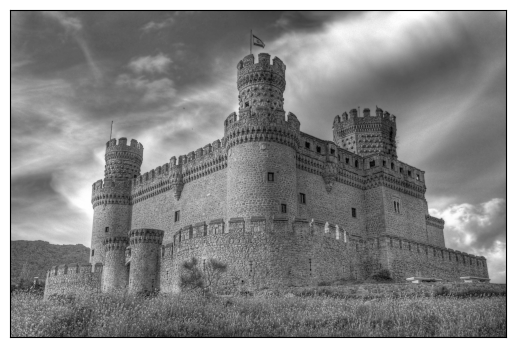

Tamaño de la foto:  (3168, 4800)


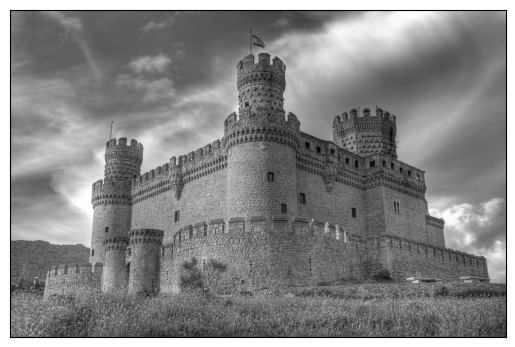

In [8]:
foto = cv2.imread("castillo.jpg", cv2.IMREAD_GRAYSCALE)

fotos = []
alto = foto.shape[0]
ancho = foto.shape[1]
# Dividir entre 10 el ancho y alto
alto = int(alto/10)
ancho = int(ancho/10)
# Obtener el nuevo tamaño de la foto
for i in range(5):
    # Obtener la foto
    foto_res = cv2.resize(foto, (ancho, alto), interpolation = cv2.INTER_AREA)
    # Guardar la foto en la lista
    fotos.append(foto_res)
    alto = alto*2
    ancho = ancho*2
# Mostrar las fotos 
for i in range(5):
        # Tamaño de la foto
        plt.figure()
        print("Tamaño de la foto: ", fotos[i].shape)
        plt.imshow(fotos[i],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

    

## Se crea el Filtro de tipo Sobel

In [9]:
filtro8 = np.array ([[-1,0,1],[-2,0,2],[-1,0,1]]) # Filtro de tipo Sobel
print("Filtro:\n", filtro8)

Filtro:
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


## Convolución de las fotos

Para la foto de tamaño  (198, 300) Tiempo de ejecucion:  0.9660064000636339
Para la foto de tamaño  (396, 600) Tiempo de ejecucion:  0.00014899997040629387
Para la foto de tamaño  (792, 1200) Tiempo de ejecucion:  0.00013929978013038635
Para la foto de tamaño  (1584, 2400) Tiempo de ejecucion:  0.00022900011390447617
foto original
Tamaño de la foto:  (3168, 4800)


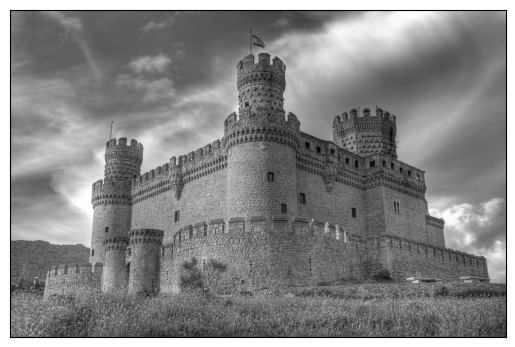

Para la foto de tamaño  (3168, 4800) Tiempo de ejecucion:  0.00030579976737499237
foto filtrada


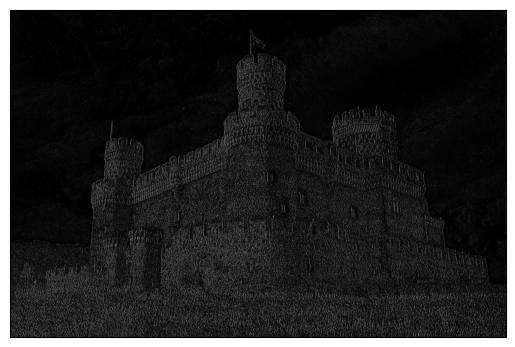



Tiempo de ejecución: 4.596989 seconds


In [10]:
s = timer()
tiempoTotal=[]
TBP = 16
for i in range (5):
  salida = np.zeros_like(fotos[i]) # Se crea una matriz de salida del tamaño de la foto
  if (i==4):
    plt.figure()
    print("foto original")
    print("Tamaño de la foto: ", fotos[i].shape)
    plt.imshow(fotos[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
  foto = cuda.to_device(fotos[i]) # Se copia la foto a la memoria de la GPU
  fil = cuda.to_device(filtro8) # Se copia el filtro a la memoria de la GPU 
  sal = cuda.to_device(salida) # Se copia la matriz de salida a la memoria de la GPU
  threadsperblock = (TBP, TBP)
  # Math.ceil redondea hacia arriba para eliminar decimales
  blockspergrid_x = math.ceil(salida.shape[0] / threadsperblock[0]) # Se calcula el número de bloques en el eje x
  blockspergrid_y = math.ceil(salida.shape[1] / threadsperblock[1]) # Se calcula el número de bloques en el eje y
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  inicio = timer()
  matmul[blockspergrid, threadsperblock](foto, fil, sal)
  fin = timer()
  tiempoTotal.append(fin-inicio)
  print("Para la foto de tamaño ", fotos[i].shape , "Tiempo de ejecucion: ", tiempoTotal[i])
  resultado = sal.copy_to_host()

  if (i==4):
    print("foto filtrada")
    plt.figure()
    plt.imshow(resultado, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print("\n")

e = timer()
print("Tiempo de ejecución: %f seconds" % (e - s))

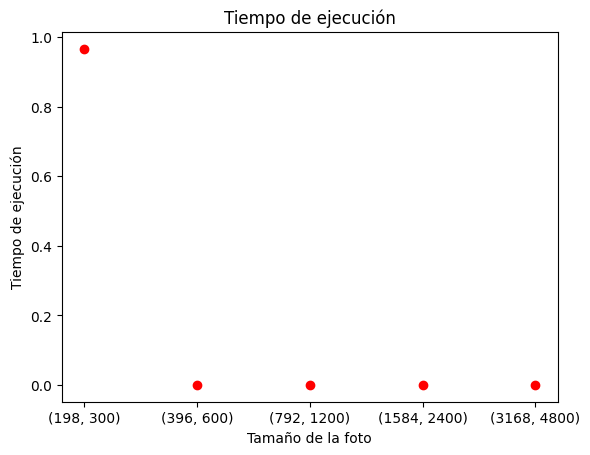

In [11]:
# Imrpime un grafico con los datos del tiempo:
plt.figure()
plt.plot([0,1,2,3,4], tiempoTotal, 'ro')
plt.xticks([0,1,2,3,4],[fotos[0].shape, fotos[1].shape, fotos[2].shape, fotos[3].shape, fotos[4].shape])
plt.title('Tiempo de ejecución')
plt.xlabel('Tamaño de la foto')
plt.ylabel('Tiempo de ejecución')
plt.show()


